# Global PCA model training

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import random
import ast
import math
from nltk.corpus import stopwords
from gensim.utils import tokenize
from lyrics_stats import lyrics_statistics
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import joblib
from gensim.models.doc2vec import Doc2Vec
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

2023-03-22 21:00:28.001956: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 21:00:28.846478: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-22 21:00:28.846561: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-22 21:00:28.846570: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
sns.set_theme(context='paper', style='white', palette='deep')

In [3]:
df = pd.read_csv('../data/lyrics.csv')

In [4]:
df.head()

,lyrics,genre,id
0,"['So long', 'My sweet love', 'I miss you', ""Mo...",pop,0
1,"[""It won't be long before I'm leaving here"", ""...",pop,1
2,"['Are we crazy?', 'Living our lives through a ...",pop,2
3,"['When did it go wrong, I will never know', 'I...",pop,3
4,"[""I've waited all this time"", 'Counting minute...",pop,4


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36000 entries, 0 to 35999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   lyrics  36000 non-null  object
 1   genre   36000 non-null  object
 2   id      36000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 843.9+ KB


In [6]:
df['lyrics'] = df['lyrics'].apply(ast.literal_eval)

In [7]:
idxs_eval = pd.read_csv('../data/evaluation/lyrics_eval.csv')['id']

In [8]:
df = df.drop(idxs_eval)
df = df.reset_index()

In [9]:
lyrics = list(df['lyrics'])
genres = list(df['genre'])

verses = [verse for lyr in lyrics for verse in lyr]
genres_by_verse = [genre for lyr, genre in zip(lyrics, genres) for verse in lyr]

lyrics_indexes = [i for i, lyr in enumerate(lyrics) for verse in lyr]
verse_indexes = [i for lyr in lyrics for i, verse in enumerate(lyr)]

df_verse = pd.DataFrame({'verse': verses, 'genre': genres_by_verse, 
                         'lyrics_id': lyrics_indexes, 'verse_id': verse_indexes})

df_verse

,verse,genre,lyrics_id,verse_id
0,So long,pop,0,0
1,My sweet love,pop,0,1
2,I miss you,pop,0,2
3,More than you'll ever know,pop,0,3
4,Goodbye my moonlight,pop,0,4
...,...,...,...,...
1828696,"And let the virgin conceive""",rock,35849,19
1828697,All the tales are told,rock,35849,20
1828698,All the orchids gone,rock,35849,21
1828699,Lost in my own world,rock,35849,22


In [10]:
#df_verse.groupby('lyrics_id').apply(lambda x: x.sample(n=2))

In [11]:
opening_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmin()]
final_verse = df_verse.loc[df_verse.groupby('lyrics_id')['verse_id'].idxmax()]
middle_verse = df_verse.groupby('lyrics_id')['verse_id'].apply(
    lambda x: x.iloc[math.ceil(len(x)/2)-1]).reset_index()
middle_verse = pd.merge(df_verse, middle_verse, on=['lyrics_id', 'verse_id'])
df_verse = pd.concat([opening_verse, final_verse, middle_verse]).reset_index(drop=True)
df_verse

,verse,genre,lyrics_id,verse_id
0,So long,pop,0,0
1,It won't be long before I'm leaving here,pop,1,0
2,Are we crazy?,pop,2,0
3,"When did it go wrong, I will never know",pop,3,0
4,I've waited all this time,pop,4,0
...,...,...,...,...
107545,What if every living soul could be upright and...,rock,35845,10
107546,"But oh, the King and the Queen of Light",rock,35846,10
107547,Cause I'm All Shook Up over Peggy Sue,rock,35847,13
107548,The more those feelings grew.,rock,35848,14


In [12]:
df_verse.shape

(107550, 4)

## Features

In [13]:
# Get features from a specific verse based on its index in the lyrics
def get_features_verse(lyrics_features, verse_idx):
    return [lyrics_features[verse_idx] for lyrics_features in lyrics_features.values()]
"""
# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j
features_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) 
                    for index, row in df_verse.iterrows()]

features_by_verse = np.array(features_by_verse)
"""

"\n# Compute lyrics statistics of lyrics with index_id i, get verse statistics from verse_id j\nfeatures_by_verse = [get_features_verse(lyrics_statistics(df['lyrics'][row['lyrics_id']]), row['verse_id']) \n                    for index, row in df_verse.iterrows()]\n\nfeatures_by_verse = np.array(features_by_verse)\n"

In [14]:
"""
scaler = StandardScaler()
scl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))
"""

'\nscaler = StandardScaler()\nscl_features_by_verse = scaler.fit_transform(np.array(features_by_verse))\n'

In [15]:
"""
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_features_by_verse)
"""

'\npca = PCA(n_components=1, random_state=42)\npca.fit(scl_features_by_verse)\n'

In [16]:
"""
joblib.dump(pca, '../models/gpca/features_pca.pkl')
joblib.dump(scaler, '../models/gpca/features_scaler.pkl')
"""

"\njoblib.dump(pca, '../models/gpca/features_pca.pkl')\njoblib.dump(scaler, '../models/gpca/features_scaler.pkl')\n"

In [17]:
scaler = joblib.load('../models/gpca/features_scaler.pkl')
pca = joblib.load('../models/gpca/features_pca.pkl')

['Seventeen...', "It's been a while since I've been seventeen", 'And the years since have been mighty lean', "But there's no use complaining", 'Forty-two...', 'has a way of creeping up on you', 'And my chances left are getting few', "But there's till time remaining.", "I've been waiting for someone", 'Who loves the way I do', "And girl I've got my fingers crossed", 'In hopes it might be you...', 'Twenty-one...', "that's how many different jobs I've done", 'I remember quitting every one', 'With no hesitating', 'And thirty-three...', "that's how many women left on me", "I don't have too good a history", "But I don't mind waiting...", "Cause it really doesn't matter", "How many years you've seen", 'Cause Love is Always Seventeen', "Wonder if you'll be the one", 'To end this lonesome heart', "'Cause girl I've got a lot to give", "And I'd sure like to start."]


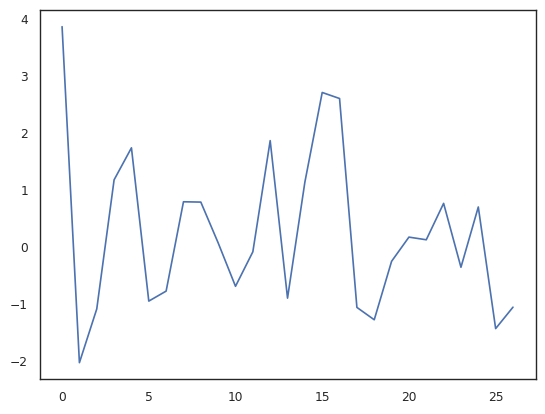

In [18]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = pd.DataFrame(lyrics_statistics(random_lyrics)).values
eg_scl_multi_ts = scaler.transform(eg_multi_ts)
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_scl_multi_ts)))
plt.plot(eg_uni_ts)

## Sentence BERT

In [19]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [20]:
"""
embeddings = df_verse['verse'].apply(lambda x: model.encode([x]))
embeddings = np.concatenate(embeddings, axis=0)
"""

"\nembeddings = df_verse['verse'].apply(lambda x: model.encode([x]))\nembeddings = np.concatenate(embeddings, axis=0)\n"

In [21]:
"""
embeddings.shape
"""

'\nembeddings.shape\n'

In [22]:
"""
pca = PCA(n_components=1, random_state=42)
pca.fit(embeddings)
"""

'\npca = PCA(n_components=1, random_state=42)\npca.fit(embeddings)\n'

In [23]:
"""
joblib.dump(pca, '../models/gpca/sbert_pca.pkl')
"""

"\njoblib.dump(pca, '../models/gpca/sbert_pca.pkl')\n"

In [24]:
pca = joblib.load('../models/gpca/sbert_pca.pkl')

['Cause I use to live', 'In a fuzzy dream', 'And I wanted to be', 'Like all the pretty people', "I'm so stupid", 'Cause I use to live', 'In a fuzzy dream', 'And I use to believe', 'In a pretty pictures', 'That were all around me', 'But now I know for sure', 'That I was stupid', "Please don't try to tempt me", 'It was just greed', "And it won't protect me", "Don't want my dreams", 'Adding up to nothing', 'I was just looking for', "Everybody's looking for something", "I'm so stupid", 'Cause I use to live', 'In a tiny bubble', 'And I wanted to be', 'Like all the pretty people', 'That were all around me', 'But now I know for sure', 'That I was stupid', 'Stupider than stupid', 'Stupider than stupid', 'Stupider than stupid', "Please don't try to tempt me", 'It was just greed', "And it won't protect me", "Don't want my dreams", 'Adding up to nothing', 'I was just looking for', "Everybody's looking for something", "Everybody's looking for something", "Everybody's stupid stupid", "Everybody's l

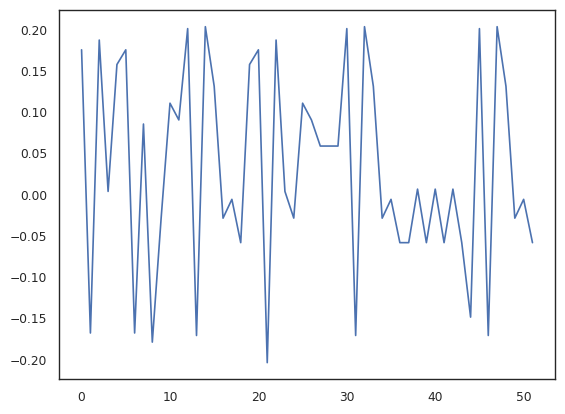

In [25]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

eg_multi_ts = np.array([model.encode(verse) for verse in random_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Doc2Vec

In [26]:
model = Doc2Vec.load("../models/d2v/doc2vec.model")

In [27]:
"""
tokenized_verses = df_verse['verse'].apply(lambda x: list(tokenize(x, lowercase=True)))
"""

"\ntokenized_verses = df_verse['verse'].apply(lambda x: list(tokenize(x, lowercase=True)))\n"

In [28]:
"""
embeddings = np.array([model.infer_vector(verse) for verse in tokenized_verses if verse])
"""

'\nembeddings = np.array([model.infer_vector(verse) for verse in tokenized_verses if verse])\n'

In [29]:
"""
scaler = StandardScaler()
scl_embeddings = scaler.fit_transform(embeddings)
"""

'\nscaler = StandardScaler()\nscl_embeddings = scaler.fit_transform(embeddings)\n'

In [30]:
"""
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_embeddings)
"""

'\npca = PCA(n_components=1, random_state=42)\npca.fit(scl_embeddings)\n'

In [31]:
"""
joblib.dump(pca, '../models/gpca/d2v_pca.pkl')
joblib.dump(scaler, '../models/gpca/d2v_scaler.pkl')
"""

"\njoblib.dump(pca, '../models/gpca/d2v_pca.pkl')\njoblib.dump(scaler, '../models/gpca/d2v_scaler.pkl')\n"

In [32]:
scaler = joblib.load('../models/gpca/d2v_scaler.pkl')
pca = joblib.load('../models/gpca/d2v_pca.pkl')

['I may not always love you', 'But long as there are stars above you', 'You never need to doubt it', "I'll make you so sure about it", "God only knows what I'd be without you", 'If you should ever leave me', 'Though life would still go on believe me', 'The world could show nothing to me', 'So what good would living do me', "God only knows what I'd be without you", "God only knows what I'd be without you", 'If you should ever leave me', 'Well life would still go on believe me', 'The world could show nothing to me', 'So what good would living do me', "God only knows what I'd be without you", "God only knows what I'd be without you", 'God only knows', "God only knows what I'd be without you", "God only knows what I'd be without you", 'God only knows', "God only knows what I'd be without you", "God only knows what I'd be without you", 'God only knows', "God only knows what I'd be without you", "God only knows what I'd be without you", 'God only knows', "God only knows what I'd be without y

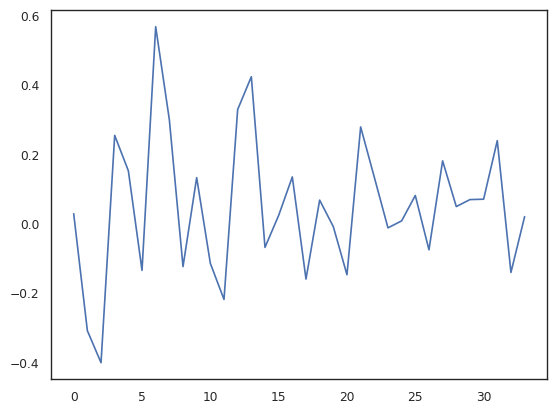

In [33]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

tokenized_lyrics = [list(tokenize(verse, lowercase=True)) for verse in random_lyrics]
    
eg_multi_ts = np.array([model.infer_vector(verse) for verse in tokenized_lyrics])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)

## Emotion

In [34]:
tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base", output_hidden_states = False)

In [35]:
def get_logits(sentence, tokenizer, model):
    inputs = tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits    
    return logits

In [36]:
def logits2label(logits, model):
    predicted_class_id = logits.argmax().item()
    label = model.config.id2label[predicted_class_id]
    return label

In [37]:
"""
logits_tensor = df_verse['verse'].sample(5000).apply(get_logits, tokenizer=tokenizer, model=model)
"""

"\nlogits_tensor = df_verse['verse'].sample(5000).apply(get_logits, tokenizer=tokenizer, model=model)\n"

In [38]:
"""
# Convert tensors to numpy array
logits = np.array([lt[0].numpy() for lt in logits_tensor])
labels = [logits2label(lt, model) for lt in logits_tensor]
"""

'\n# Convert tensors to numpy array\nlogits = np.array([lt[0].numpy() for lt in logits_tensor])\nlabels = [logits2label(lt, model) for lt in logits_tensor]\n'

In [39]:
"""
tsne_model = TSNE(n_components=2, random_state=42, init='pca')
"""

"\ntsne_model = TSNE(n_components=2, random_state=42, init='pca')\n"

In [40]:
"""
tsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])
tsne_logits['label'] = labels
"""

"\ntsne_logits = pd.DataFrame(tsne_model.fit_transform(logits), columns=['x','y'])\ntsne_logits['label'] = labels\n"

In [41]:
"""
tsne_logits.to_csv('../data/other/tsne_emo_logits.csv', index=False)
"""

"\ntsne_logits.to_csv('../data/other/tsne_emo_logits.csv', index=False)\n"

In [42]:
tsne_logits = pd.read_csv('../data/other/tsne_emo_logits.csv')
tsne_logits

,x,y,label
0,-2.194073,-41.235817,neutral
1,12.846179,61.438618,sadness
2,50.015774,6.370952,disgust
3,-46.278404,-40.801163,joy
4,-21.933517,41.302338,surprise
...,...,...,...
4995,-7.399046,-19.725868,neutral
4996,-26.131702,38.406260,surprise
4997,2.579892,26.106485,neutral
4998,-36.084267,41.825798,surprise


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


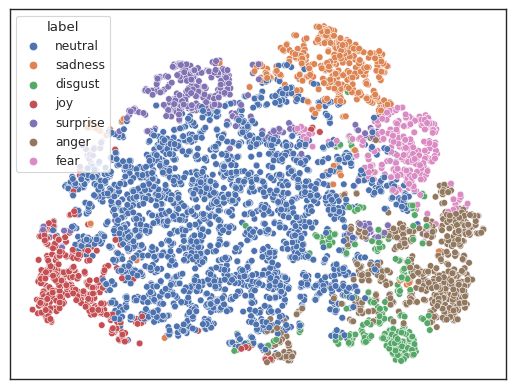

In [43]:
fig, ax = plt.subplots()
ax = sns.scatterplot(data=tsne_logits, x='x', y='y', hue='label')
#ax.set_title('T-SNE representation of emotion logits')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_ylabel('')
plt.savefig('../pgf/tsne_emotions.pgf', backend='pgf')

In [44]:
"""
scaler = StandardScaler()
scl_logits = scaler.fit_transform(logits)
"""

'\nscaler = StandardScaler()\nscl_logits = scaler.fit_transform(logits)\n'

In [45]:
"""
pca = PCA(n_components=1, random_state=42)
pca.fit(scl_logits)
"""

'\npca = PCA(n_components=1, random_state=42)\npca.fit(scl_logits)\n'

In [46]:
"""
joblib.dump(pca, '../models/gpca/emo_pca.pkl')
joblib.dump(scaler, '../models/gpca/emo_scaler.pkl')
"""

"\njoblib.dump(pca, '../models/gpca/emo_pca.pkl')\njoblib.dump(scaler, '../models/gpca/emo_scaler.pkl')\n"

In [47]:
scaler = joblib.load('../models/gpca/emo_scaler.pkl')
pca = joblib.load('../models/gpca/emo_pca.pkl')

['Baby the harder you work the further you get with me,', 'With me.', 'I think you can.', 'I think you can.', 'Turn up prepared and make sure you can keep up with me', 'With me.', 'I think you can,', 'I think you can.', 'But be aware I always get what I deserve.', 'Keep your focus keep you nerve.', 'Ready.', 'Set.', 'Go.', 'Pick up the pace and step on it!', 'Rip up the place if you want it!', 'Work!', 'Work!', 'You know you gotta work!', 'Work!', 'I got the goods and I want you.', 'Put your boots on baby get to work!', 'Work!', 'You know you gotta work!', 'Work!', 'I tend to get what I want so are you starting to see?', 'I think you do.', 'I think you do.', "It's time for you to step up if you wanna be with me,", 'With me.', 'I think you do.', 'I think you do.', "But don't go slow.", 'That is not the way we play.', 'Slowly aint my kind of game.', 'Ready.', 'Set.', 'Go.', 'Pick up the pace and step on it!', 'Rip up the place if you want it!', 'Work!', 'Work!', 'You know you gotta work!

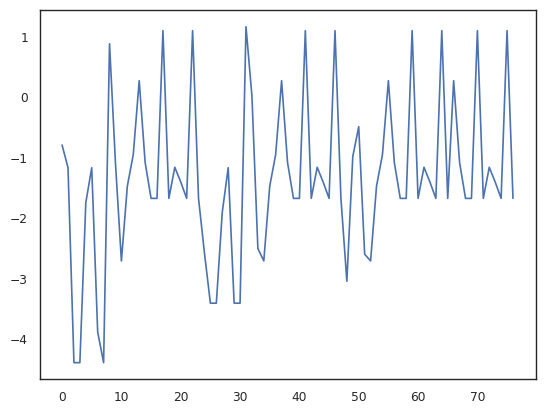

In [48]:
random_lyrics = random.choice(df['lyrics'])

print(random_lyrics)

logits_tensor = [get_logits(verse, tokenizer=tokenizer, model=model) for verse in random_lyrics]

# Convert tensors to numpy array
eg_multi_ts = np.array([lt[0].numpy() for lt in logits_tensor])
eg_uni_ts = list(map(
    lambda unique_element: unique_element[0], pca.transform(eg_multi_ts)))
plt.plot(eg_uni_ts)